# **Project: Document Scanning for Book Pages**

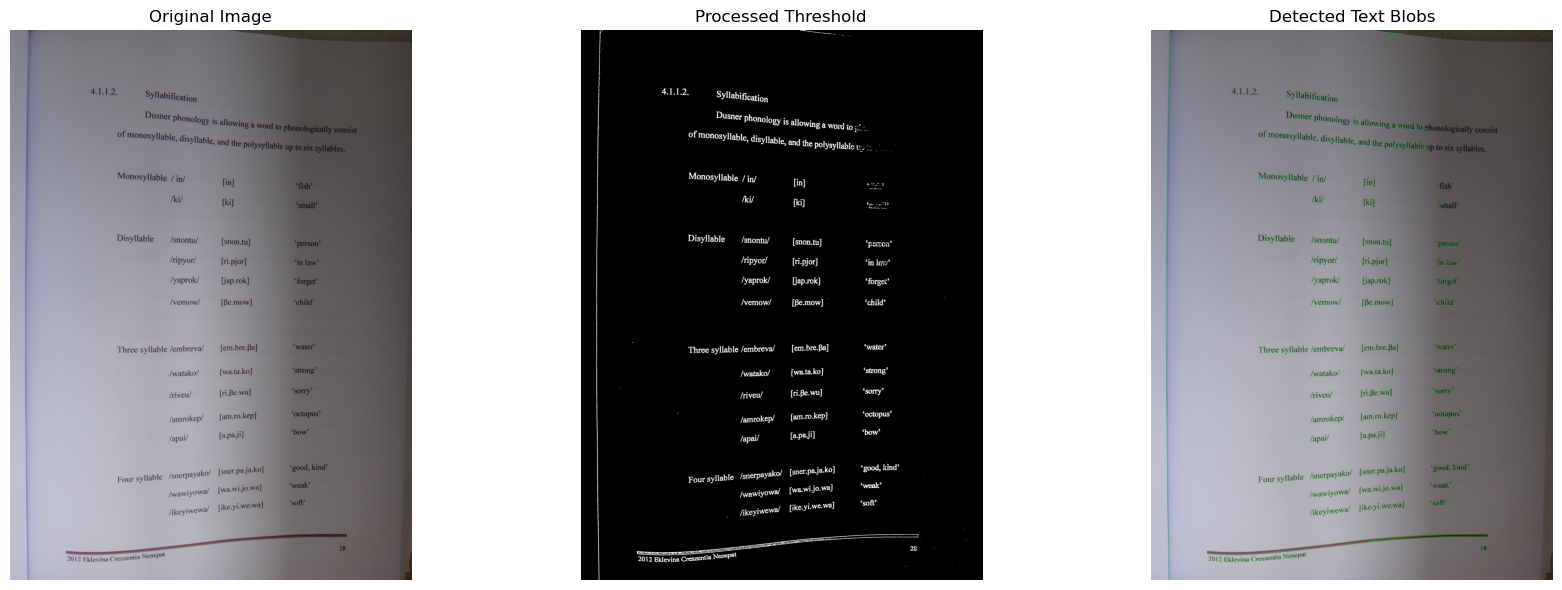

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_text_blobs(image_path):
    # Step 1: Load and Preprocess Image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image.")
        return
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape

    # Step 2: Crop the Image to Remove Borders
    margin = int(min(height, width) * 0.05)  # 5% margin
    cropped = gray[margin:height-margin, margin:width-margin]

    # Step 3: Normalize and Enhance Contrast
    normalized = cv2.normalize(cropped, None, 0, 255, cv2.NORM_MINMAX)
    equalized = cv2.equalizeHist(normalized)

    # Step 4: Gaussian Blur to Reduce Noise
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)

    # Step 5: Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, blockSize=15, C=9
    )

    # Step 6: Morphological Operations
    # a. Closing to Connect Text Regions
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close, iterations=2)

    # b. Opening to Remove Small Noise
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open, iterations=1)

    # Step 7: Dilation to Enhance Text Blobs
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilated = cv2.dilate(opened, kernel_dilate, iterations=1)

    # Step 8: Connected Component Analysis
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 9: Filter and Approximate Contours
    filtered_contours = []
    min_area = 100  # Minimum area threshold
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            filtered_contours.append(contour)

    # Step 10: Draw Contours on Original Image
    output_image = image[margin:height-margin, margin:width-margin].copy()
    cv2.drawContours(output_image, filtered_contours, -1, (0, 255, 0), 1)

    # Step 11: Visualize Results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image[margin:height-margin, margin:width-margin], cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Processed Threshold")
    plt.imshow(dilated, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Detected Text Blobs")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    
    plt.tight_layout()
    plt.show()

# Example usage
detect_text_blobs("linguistics_thesis_a.jpg")


Document contour not detected.


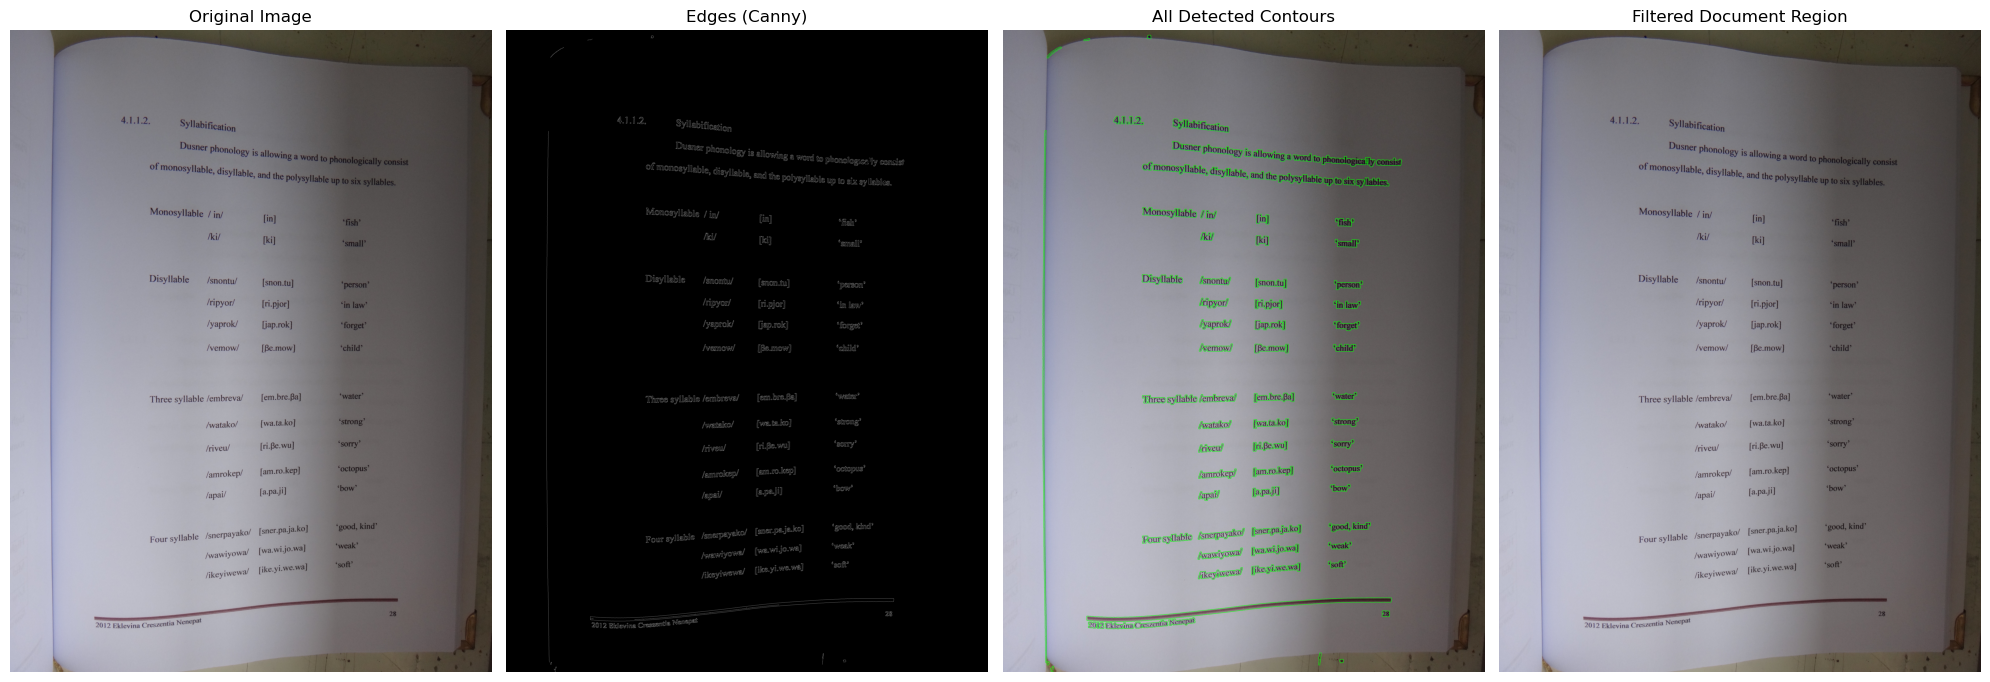

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_document_blob(image_path):
    # Step 1: Load the Image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image.")
        return
    original_image = image.copy()

    # Step 2: Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 3: Apply Gaussian Blur to Reduce Noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Step 4: Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)

    # Step 5: Perform Morphological Dilation to Enhance Edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated_edges = cv2.dilate(edges, kernel, iterations=2)

    # Step 6: Detect Contours
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 7: Filter Contours Based on Area and Shape
    filtered_contours = []
    document_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 5000:  # Minimum area threshold to ignore small blobs
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
            if len(approx) == 4:  # Only consider quadrilateral shapes
                filtered_contours.append(contour)
                document_contour = approx

    # Step 8: Draw All Contours and Document Contour Separately
    all_contours_image = original_image.copy()
    cv2.drawContours(all_contours_image, contours, -1, (0, 255, 0), 2)

    document_contour_image = original_image.copy()
    if document_contour is not None:
        cv2.drawContours(document_contour_image, [document_contour], -1, (255, 0, 0), 3)
    else:
        print("Document contour not detected.")

    # Step 9: Visualize the Results
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Edges (Canny)")
    plt.imshow(edges, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("All Detected Contours")
    plt.imshow(cv2.cvtColor(all_contours_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("Filtered Document Region")
    plt.imshow(cv2.cvtColor(document_contour_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example Usage
detect_document_blob("linguistics_thesis_a.jpg")
